In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pandas_profiling
import datasist as ds                            #For data cleaning 
import pickle
# Show plots in jupyter notebook
%matplotlib inline
# Set plot style
sns.set(color_codes=True)
# Set maximum number of columns to be displayed
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',150)
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Modeling
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,LabelEncoder,StandardScaler


# Load Data

In [2]:
#Load loan data
print('------------Train set---------------------')
loan_data = pd.read_csv('loan_data_train.csv')
display(loan_data.head(4))


#Test set
print('------------Test set---------------------')
loan_data_test = pd.read_csv('loan_data_test.csv')
display(loan_data_test.head(4))

# Load data dictionary
print('------------Data Dictionary---------------------')
data_info = pd.read_csv("DataDictionary2.csv", index_col="Columns", encoding="ISO-8859-1").dropna()

# Increase the width of the description column to view text
# display(data_info.style.set_properties(subset=['Description'], **{'width' :'500px'}))

# Create function to look-up description of any columns
def col_desc(col_name):
    print(data_info.loc[col_name]['Description'])
    
print(col_desc('revol_util'))

------------Train set---------------------


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,int_rate,grade
0,545977,48654285,25000.0,25000.0,25000.0,36 months,833.83,C1,Respiratory Manager,10+ years,MORTGAGE,106000.0,Source Verified,May-2015,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,913xx,CA,18.99,0.0,Feb-1995,665.0,669.0,1.0,44.0,NaN,31.0,0.0,14165.0,63.2,45.0,w,0.0,0.0,26645.500000,26645.50,25000.00,1645.50,0.0,0.0,0.0,Jan-2016,22510.49,NaN,Dec-2017,734.0,730.0,...,NaN,NaN,NaN,NaN,22400.0,NaN,NaN,NaN,12.0,13289.0,1328.0,85.7,0.0,0.0,243.0,174.0,6.0,6.0,3.0,6.0,NaN,6.0,NaN,0.0,7.0,13.0,9.0,12.0,20.0,17.0,21.0,13.0,31.0,0.0,0.0,0.0,3.0,97.8,57.1,0.0,0.0,413442.0,78492.0,9300.0,69882.0,N,Cash,N,12.29,C
1,892728,5626429,3125.0,3125.0,3125.0,36 months,111.84,C5,Broadcom Corporation,10+ years,RENT,112000.0,Not Verified,Jun-2013,Fully Paid,n,NaN,debt_consolidation,Personal,926xx,CA,10.95,1.0,Jul-2000,680.0,684.0,0.0,23.0,NaN,6.0,0.0,5420.0,73.2,16.0,f,0.0,0.0,4026.013171,4026.01,3125.00,901.01,0.0,0.0,0.0,Jun-2016,111.61,NaN,Dec-2017,734.0,730.0,...,NaN,NaN,NaN,NaN,7400.0,NaN,NaN,NaN,4.0,5593.0,211.0,29.7,0.0,0.0,81.0,157.0,13.0,8.0,2.0,13.0,41.0,8.0,35.0,3.0,1.0,4.0,1.0,3.0,6.0,5.0,8.0,4.0,6.0,0.0,0.0,1.0,1.0,62.0,0.0,0.0,0.0,59695.0,27966.0,300.0,52295.0,N,Cash,N,17.27,C
2,171760,14660646,8025.0,8025.0,8025.0,60 months,197.68,D1,Associate Buyer,9 years,MORTGAGE,76791.0,Not Verified,Apr-2014,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,601xx,IL,6.27,0.0,Mar-1989,675.0,679.0,2.0,44.0,NaN,6.0,0.0,6164.0,60.4,20.0,w,0.0,0.0,9607.800000,9607.80,8024.99,1582.81,0.0,0.0,0.0,Dec-2015,154.69,NaN,Dec-2017,704.0,700.0,...,NaN,NaN,NaN,NaN,10200.0,NaN,NaN,NaN,0.0,45135.0,94.0,98.3,0.0,0.0,170.0,217.0,25.0,25.0,6.0,77.0,44.0,0.0,44.0,2.0,2.0,3.0,2.0,7.0,3.0,4.0,10.0,3.0,6.0,0.0,0.0,0.0,0.0,80.0,100.0,0.0,0.0,308200.0,13134.0,5500.0,10000.0,N,Cash,N,16.59,D
3,866234,6607685,5000.0,5000.0,5000.0,36 months,177.72,C5,Emerging Global Advisors,2 years,RENT,125000.0,Source Verified,Aug-2013,Fully Paid,n,NaN,debt_consolidation,Debt consolidation loan,100xx,NY,7.69,0.0,Feb-2004,665.0,669.0,0.0,62.0,NaN,9.0,0.0,15181.0,96.7,20.0,f,0.0,0.0,5628.738968,5628.74,5000.00,628.74,0.0,0.0,0.0,Jun-2014,4030.73,NaN,Jul-2014,724.0,720.0,...,NaN,NaN,NaN,NaN,15700.0,NaN,NaN,NaN,4.0,2953.0,519.0,96.7,0.0,0.0,103.0,115.0,5.0,5.0,0.0,5.0,NaN,NaN,NaN,0.0,7.0,7.0,7.0,12.0,8.0,7.0,12.0,7.0,9.0,0.0,0.0,0.0,2.0,95.0,100.0,0.0,0.0,38098.0,26577.0,15700.0,22398.0,N,Cash,N,16.78,C


------------Test set---------------------


,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,836568,7680704,15000.0,15000.0,15000.0,36 months,535.54,C5,Associate Athletic Director,6 years,MORTGAGE,83000.0,Not Verified,Oct-2013,Fully Paid,n,NaN,moving,Moving Expenses,302xx,GA,14.75,0.0,Sep-1994,710.0,714.0,0.0,NaN,NaN,6.0,0.0,23181.0,88.1,14.0,w,0.00,0.00,15422.920000,15422.92,15000.00,422.92,0.0,0.0,0.0,Dec-2013,14887.38,NaN,Dec-2017,709.0,705.0,...,NaN,NaN,NaN,NaN,NaN,NaN,26300.0,NaN,NaN,NaN,2.0,38640.0,856.0,95.8,0.0,0.0,169.0,232.0,28.0,16.0,4.0,83.0,NaN,17.0,NaN,0.0,2.0,4.0,2.0,5.0,3.0,4.0,7.0,4.0,6.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,242934.0,37641.0,20400.0,18634.0,N,Cash,N
1,1356496,78820328,10000.0,10000.0,10000.0,36 months,325.62,A5,Assistant attorney general III,2 years,RENT,63000.0,Source Verified,May-2016,Current,n,NaN,credit_card,Credit card refinancing,799xx,TX,26.15,0.0,Sep-2006,715.0,719.0,0.0,NaN,NaN,9.0,0.0,14399.0,97.3,35.0,w,4936.08,4936.08,5956.770000,5956.77,5063.92,892.85,0.0,0.0,0.0,Dec-2017,330.00,Jan-2018,Dec-2017,659.0,655.0,...,181625.0,72.0,0.0,0.0,5365.0,79.0,14800.0,0.0,1.0,0.0,1.0,21780.0,401.0,97.3,0.0,0.0,115.0,107.0,35.0,5.0,0.0,35.0,NaN,NaN,NaN,0.0,3.0,3.0,3.0,3.0,31.0,3.0,4.0,3.0,9.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,228463.0,196024.0,14800.0,213663.0,N,Cash,N
2,938658,2837522,18825.0,18825.0,18750.0,36 months,644.22,B5,the home depot,10+ years,RENT,42000.0,Verified,Jan-2013,Fully Paid,n,Borrower added on 12/28/12 > Bill consolidat...,debt_consolidation,consolidation,190xx,PA,15.46,0.0,Sep-1998,665.0,669.0,0.0,NaN,103.0,6.0,1.0,7655.0,72.2,17.0,f,0.00,0.00,23191.789548,23099.39,18825.00,4366.79,0.0,0.0,0.0,Jan-2016,644.08,NaN,Jan-2016,759.0,755.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10600.0,NaN,NaN,NaN,2.0,3390.0,2528.0,75.0,0.0,0.0,129.0,174.0,20.0,13.0,0.0,27.0,NaN,23.0,NaN,0.0,4.0,5.0,4.0,13.0,3.0,5.0,14.0,5.0,6.0,0.0,0.0,0.0,0.0,100.0,75.0,1.0,0.0,26079.0,20338.0,10100.0,15479.0,N,Cash,N
3,981452,1250836,18000.0,18000.0,18000.0,36 months,571.56,A5,Devellis Zrein Inc.,10+ years,MORTGAGE,160000.0,Not Verified,May-2012,Fully Paid,n,Borrower added on 04/19/12 > intend to payof...,debt_consolidation,Debt consolidation loan,019xx,MA,3.76,0.0,Dec-1999,745.0,749.0,1.0,NaN,NaN,6.0,0.0,26677.0,64.6,16.0,f,0.00,0.00,19733.217301,19733.22,18000.00,1733.22,0.0,0.0,0.0,Sep-2013,11171.18,NaN,Sep-2013,794.0,790.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,13123.0,67.0,0.0,0.0,NaN,NaN,NaN,NaN,5.0,12.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,0.0,0.0,NaN,26677.0,39800.0,NaN,N,Cash,N


------------Data Dictionary---------------------
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
None


In [3]:
# Data dimension
print('------------------Data Dimension----------------------')
print('-------------------Train Set---------------------------')
print(loan_data.shape)
print('-------------------Test Set---------------------------')
print(loan_data_test.shape)

------------------Data Dimension----------------------
-------------------Train Set---------------------------
(75000, 114)
-------------------Test Set---------------------------
(75000, 112)


# Data Pre-processing

## Reduce complexity of the data

* Delete columns with missing value percentage above 40%
* Delete columns generated after a loan have been issued
* Delete redundant columns

### Drop Columns with over 50% Missing Value

In [4]:
# Function to check missing value
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'vissing_values', 1 : 'percentage'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    'percentage', ascending=False).round(1)
    print("Dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

# Check missing values
missing_recs = missing_values_table(loan_data)
display(missing_recs)
missing_50_perc = missing_recs[missing_recs['percentage'] >= 50.0].index
print(missing_50_perc)

Dataframe has 114 columns.
There are 66 columns that have missing values.


,vissing_values,percentage
desc,69655,92.9
mths_since_last_record,62312,83.1
mths_since_recent_bc_dlq,56669,75.6
mths_since_last_major_derog,54833,73.1
mths_since_recent_revol_delinq,49199,65.6
il_util,44224,59.0
mths_since_rcnt_il,40401,53.9
all_util,39454,52.6
inq_fi,39450,52.6
total_cu_tl,39450,52.6


Index(['desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq',
       'mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
       'il_util', 'mths_since_rcnt_il', 'all_util', 'inq_fi', 'total_cu_tl',
       'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'inq_last_12m',
       'total_bal_il'],
      dtype='object')


In [5]:
# Delete columns containing either 50% or more than 50% missing Values
cols = ['desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq',
       'mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
       'il_util', 'mths_since_rcnt_il', 'all_util', 'inq_fi', 'total_cu_tl',
       'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'inq_last_12m',
       'total_bal_il']
loan_data.drop(cols, axis=1, inplace=True)
loan_data.shape

(75000, 95)

### Drop unwanted features and feature gotten after loan grading

In [6]:
# Drop columns that are not needed, redundant or have high cardinality
cols = ['Unnamed: 0', 'funded_amnt_inv', 'policy_code', 'disbursement_method','emp_title', 'title', 'zip_code', 
        'total_pymnt_inv', 'last_credit_pull_d', 'addr_state', 'issue_d', 'earliest_cr_line','int_rate',
       'acc_now_delinq', 'delinq_amnt', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'tax_liens']

loan_data.drop(cols, axis=1, inplace=True)
loan_data.shape

(75000, 77)

In [7]:
# Delete columns that will only be available after a loan have been graded
cols = ['revol_bal', 'out_prncp', 'out_prncp_inv', 'total_rec_prncp', 
        'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d','next_pymnt_d', 
        'last_pymnt_amnt', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'total_pymnt','sub_grade']
 

loan_data.drop(cols, axis=1, inplace=True)
loan_data.shape

(75000, 62)

### Drop columns in which missing values cannot be imputed

In [8]:
# Check missing values
missing_recs = missing_values_table(loan_data)
missing_recs

Dataframe has 62 columns.
There are 37 columns that have missing values.


,vissing_values,percentage
mths_since_last_delinq,36909,49.2
mths_since_recent_inq,9873,13.2
mo_sin_old_il_acct,5087,6.8
emp_length,3882,5.2
pct_tl_nvr_dlq,2997,4.0
tot_hi_cred_lim,2987,4.0
num_tl_op_past_12m,2987,4.0
num_tl_90g_dpd_24m,2987,4.0
num_rev_tl_bal_gt_0,2987,4.0
num_rev_accts,2987,4.0


**Some columns are observed to have 4% missing records which signifies that these records might be missing across all rows. This will be further investigated and if its found to be true all of such rows will be dropped from the data**

In [9]:
# Variables with 4% missing records
missing_4_perc = missing_recs[missing_recs['percentage'] == 4.0]
display(missing_4_perc)
print(missing_4_perc.index)

,vissing_values,percentage
pct_tl_nvr_dlq,2997,4.0
tot_hi_cred_lim,2987,4.0
num_tl_op_past_12m,2987,4.0
num_tl_90g_dpd_24m,2987,4.0
num_rev_tl_bal_gt_0,2987,4.0
num_rev_accts,2987,4.0
num_op_rev_tl,2987,4.0
num_il_tl,2987,4.0
num_bc_tl,2987,4.0
num_actv_rev_tl,2987,4.0


Index(['pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'num_tl_op_past_12m',
       'num_tl_90g_dpd_24m', 'num_rev_tl_bal_gt_0', 'num_rev_accts',
       'num_op_rev_tl', 'num_il_tl', 'num_bc_tl', 'num_actv_rev_tl',
       'num_actv_bc_tl', 'num_accts_ever_120_pd', 'total_il_high_credit_limit',
       'total_rev_hi_lim', 'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op',
       'tot_coll_amt', 'mo_sin_old_rev_tl_op', 'avg_cur_bal', 'tot_cur_bal'],
      dtype='object')


In [10]:
cols_4_perc = ['pct_tl_nvr_dlq', 'num_tl_op_past_12m', 'num_tl_90g_dpd_24m',
        'num_rev_tl_bal_gt_0', 'num_rev_accts','tot_hi_cred_lim', 'num_op_rev_tl', 
        'num_il_tl', 'num_bc_tl','num_actv_bc_tl', 'num_accts_ever_120_pd', 'num_actv_rev_tl',
       'total_il_high_credit_limit', 'total_rev_hi_lim', 'tot_coll_amt',
       'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_rev_tl_op',
       'tot_cur_bal', 'avg_cur_bal']
df_with_4_perc_missing_val = loan_data[cols_4_perc]
print(df_with_4_perc_missing_val.shape)

# Snapshot of the data
df = df_with_4_perc_missing_val[df_with_4_perc_missing_val[cols_4_perc].isnull()]
df.head()

(75000, 20)


,pct_tl_nvr_dlq,num_tl_op_past_12m,num_tl_90g_dpd_24m,num_rev_tl_bal_gt_0,num_rev_accts,tot_hi_cred_lim,num_op_rev_tl,num_il_tl,num_bc_tl,num_actv_bc_tl,num_accts_ever_120_pd,num_actv_rev_tl,total_il_high_credit_limit,total_rev_hi_lim,tot_coll_amt,mo_sin_rcnt_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,tot_cur_bal,avg_cur_bal
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**This indicates that all columns with 4% missing records have these missing values in exactly the same rows. All of such records will dropped.**

In [11]:
# Drop all rows with missing values in the columns specified above
loan_data = loan_data.dropna(axis=0, how="any", subset=cols_4_perc)
loan_data.shape

(72003, 62)

* **mths_since_last_delinq** represents the number of months since the borrower is behind on payments. This column contain 48.5% missing value. It is very crucial in scoring a loan so a good approach to correct missing values will be to drop all row with missing value as it will be erronous to fill missing values using the mean. However, 48% is almost half of the available data so dropping these rows will leave me with little data to train the model. Thus the column will be deleted instead. The same applies to **mths_since_recent_inq** which has 10.6% missing value.

In [12]:
# Drop columns
cols = ['mths_since_last_delinq','mths_since_recent_inq']
loan_data.drop(cols, axis=1, inplace=True)
loan_data.shape

(72003, 60)

In [13]:
# Check missing values
missing_recs = missing_values_table(loan_data)
display(missing_recs)
print(missing_recs.index)

Dataframe has 60 columns.
There are 8 columns that have missing values.


,vissing_values,percentage
emp_length,3804,5.3
mo_sin_old_il_acct,2099,2.9
bc_util,812,1.1
percent_bc_gt_75,785,1.1
bc_open_to_buy,766,1.1
mths_since_recent_bc,719,1.0
revol_util,45,0.1
dti,17,0.0


Index(['emp_length', 'mo_sin_old_il_acct', 'bc_util', 'percent_bc_gt_75',
       'bc_open_to_buy', 'mths_since_recent_bc', 'revol_util', 'dti'],
      dtype='object')


### Drop Duplicated and Redundant records

In [14]:
# Function to print duplicated entries
def get_duplicated(df):
    # generate count statistics of duplicate entries
    if len(df[df.duplicated()]) > 0:
        print("No. of duplicated entries: ", len(df[df.duplicated()]))
        print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
    else:
        print("No duplicated entries found")

In [15]:
# Print redundant rows
get_duplicated(loan_data)

No duplicated entries found


In [16]:
# dropping ALL duplicte values if any
loan_data.drop_duplicates(subset ="id", 
                     keep = "first", inplace = True)


# Data Engineering

In [17]:
categorical = ['term', 'home_ownership', 'verification_status', 'loan_status','purpose',
 'initial_list_status','application_type','hardship_flag','debt_settlement_flag','grade']

ordinal = ['emp_length', 'num_tl_90g_dpd_24m','num_accts_ever_120_pd','delinq_2yrs','inq_last_6mths',
'open_acc','total_acc', 'acc_open_past_24mths','mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',        
'mo_sin_rcnt_rev_tl_op','mort_acc','mo_sin_rcnt_tl','mths_since_recent_bc','num_actv_bc_tl','num_actv_rev_tl',
'num_sats','num_bc_sats','num_bc_tl','num_il_tl']

#Get continuous variables
# variables = loan_data_clean2.columns
# loan_data_clean2[[x for x in variables if x not in categorical and x not in ordinal]].dtypes

continuous = ['loan_amnt','funded_amnt','installment', 'annual_inc','dti','fico_range_low','fico_range_high', 'pub_rec',
'revol_util','last_fico_range_high','last_fico_range_low', 'tot_coll_amt','tot_cur_bal', 'total_rev_hi_lim',
'avg_cur_bal', 'bc_open_to_buy','bc_util','num_op_rev_tl', 'num_rev_accts','num_rev_tl_bal_gt_0','num_tl_op_past_12m',
'pct_tl_nvr_dlq','percent_bc_gt_75', 'pub_rec_bankruptcies','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit',
'total_il_high_credit_limit']

## Formatting and Cardinality Reduction

In [18]:
# Various categories of employment length
loan_data.emp_length.value_counts()

10+ years    24297
2 years       6541
< 1 year      5913
3 years       5779
1 year        4865
5 years       4475
4 years       4202
6 years       3260
8 years       3104
7 years       2962
9 years       2801
Name: emp_length, dtype: int64

In [19]:
# Format classes of employment length variable
emp_len_map = {
    '< 1 year': '0',
    '1 year': '1',
    '2 years': '2',
    '3 years': '3',
    '4 years': '4',
    '5 years': '5',
    '6 years': '6',
    '7 years': '7',
    '8 years': '8',
    '9 years': '9',
    '10+ years': '10',
}

loan_data.emp_length = loan_data.emp_length.map(emp_len_map)

In [20]:
# Various categories of home ownership
loan_data.home_ownership.value_counts()

MORTGAGE    35486
RENT        28672
OWN          7819
ANY            22
NONE            4
Name: home_ownership, dtype: int64

**Classes like OWN, ANY and OTHER have little entries. To reduce the cardinality of the data these classes will be merged to the RENT class.**

In [21]:
# Format classes of home ownership variable
home_own_map = {
    'MORTGAGE': 'MORTGAGE',
    'OWN': 'OWN',
    'RENT': 'RENT',
    'ANY': 'RENT',
    'NONE': 'RENT',
    'OTHER': 'RENT'
}
loan_data.home_ownership = loan_data.home_ownership.map(home_own_map)

In [22]:
# Various categories of term
loan_data.term.value_counts()

 36 months    51365
 60 months    20638
Name: term, dtype: int64

In [23]:
# Format classes of term variable
loan_data["term"] = np.where(loan_data["term"].str.contains("36 months"), '36', '60')

In [24]:
# Various categories of purpose
loan_data.purpose.value_counts()

debt_consolidation    42086
credit_card           16262
home_improvement       4685
other                  3934
major_purchase         1507
medical                 820
small_business          693
car                     679
vacation                479
moving                  471
house                   310
renewable_energy         40
wedding                  37
Name: purpose, dtype: int64

In [25]:
# Format classes of purpose variable
purpose_map = {
    "debt_consolidation" :"debt_consolidation",
    "credit_card"        :"credit_card",
    "home_improvement"   :"wellbeing",
    "other"              :"other",
    "major_purchase"     :"major_purchase",
    "medical"            :"Wellbeing",
    "small_business"     :"other",
    "car"                :"other",
    "moving"             :"Wellbeing",
    "vacation"           :"wellbeing",
    "house"              :"wellbeing",
    "wedding"           :"wellbeing",
    "renewable_energy"   :"other",
    "educational"        :"other",
}

loan_data.purpose = loan_data.purpose.map(purpose_map)

In [26]:
# Various categories of initial listing
loan_data.initial_list_status.value_counts()

w    46499
f    25504
Name: initial_list_status, dtype: int64

In [27]:
# Format classes of initial listing variable
listing_map = {
    'w': 'whole',
    'f': 'fraction',
}

loan_data.initial_list_status = loan_data.initial_list_status.map(listing_map)

In [28]:
# Various categories of loan status
loan_data.loan_status.value_counts()

Current               36322
Fully Paid            26654
Charged Off            7207
Late (31-120 days)     1084
In Grace Period         486
Late (16-30 days)       246
Default                   4
Name: loan_status, dtype: int64

**Loan status will be grouped into three classes namely:**
* Current: All loans that are current or in grace period 
* Fully paid: All loans that have been paid in full
* Default: All loans that were charged off, late or defaulted

In [29]:
# Format classes of loan status variable
loan_stat_map = {
    'Current': 'Current',
    'Fully Paid': 'Fully Paid',
    'Charged Off': 'Default',
    'Late (31-120 days)': 'Default',
    'In Grace Period': 'Current',
    'Late (16-30 days)': 'Default',
    'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid',
    'Does not meet the credit policy. Status:Charged Off': 'Default',
    'Default': 'Default',
}

loan_data.loan_status = loan_data.loan_status.map(loan_stat_map)

## Handling Missing Values

In [30]:
# Check missing values
missing_recs = missing_values_table(loan_data)
display(missing_recs)
print(missing_recs.index)

Dataframe has 60 columns.
There are 8 columns that have missing values.


,vissing_values,percentage
emp_length,3804,5.3
mo_sin_old_il_acct,2099,2.9
bc_util,812,1.1
percent_bc_gt_75,785,1.1
bc_open_to_buy,766,1.1
mths_since_recent_bc,719,1.0
revol_util,45,0.1
dti,17,0.0


Index(['emp_length', 'mo_sin_old_il_acct', 'bc_util', 'percent_bc_gt_75',
       'bc_open_to_buy', 'mths_since_recent_bc', 'revol_util', 'dti'],
      dtype='object')


In [31]:
df2 = loan_data[['emp_length', 'mo_sin_old_il_acct', 'bc_util', 'percent_bc_gt_75',
       'bc_open_to_buy', 'mths_since_recent_bc', 'revol_util', 'dti']]
df2.mean()

mo_sin_old_il_acct       126.639692
bc_util                   61.067653
percent_bc_gt_75          46.106704
bc_open_to_buy          9826.372882
mths_since_recent_bc      24.601453
revol_util                52.872091
dti                       18.526351
dtype: float64

In [32]:
# fill missing values in numeric variables with the mean
loan_data = loan_data.fillna(loan_data.mean())

# Check missing values
missing_recs = missing_values_table(loan_data)
display(missing_recs)

Dataframe has 60 columns.
There are 1 columns that have missing values.


,vissing_values,percentage
emp_length,3804,5.3


**Replace missing value in emp_length with the mode**

In [33]:
loan_data['emp_length'].fillna(loan_data['emp_length'].mode()[0], inplace=True)
# Check missing values
missing_recs = missing_values_table(loan_data)
display(missing_recs)

Dataframe has 60 columns.
There are 0 columns that have missing values.


,vissing_values,percentage


## Handling outliers

In [34]:
# Get count of outlier values in every column
def outlier_value_count(df):
    num_feats = ds.structdata.get_num_feats(df)
    Q1=df[num_feats].quantile(0.05)
    Q3=df[num_feats].quantile(0.95)
    IQR=Q3-Q1
    lower_bound=Q1 - 1.5 * IQR
    upper_bound=Q3 + 1.5 * IQR
    return ((df[num_feats] < lower_bound) | (df[num_feats] > upper_bound)).sum()


#Show outlier count in entire data
# Outlier value count of historical customer data
print("Outlier value count of loan data")
outlier_value_count(loan_data)

Outlier value count of loan data


id                               0
loan_amnt                        0
funded_amnt                      0
installment                      0
annual_inc                     317
dti                             46
delinq_2yrs                    364
fico_range_low                   0
fico_range_high                  0
inq_last_6mths                  28
open_acc                        23
pub_rec                        810
revol_util                       0
total_acc                        6
last_fico_range_high            11
last_fico_range_low            950
tot_coll_amt                  1718
tot_cur_bal                    140
total_rev_hi_lim               337
acc_open_past_24mths            42
avg_cur_bal                    212
bc_open_to_buy                 281
bc_util                          1
mo_sin_old_il_acct               7
mo_sin_old_rev_tl_op             0
mo_sin_rcnt_rev_tl_op          246
mo_sin_rcnt_tl                 367
mort_acc                        52
mths_since_recent_bc

**Outliers where corrected by setting the lower and upper boundary of every numeric variable to the 5th and 95th percentile values respectively**

In [35]:
num_col = loan_data.select_dtypes(include=['int64','float64']).columns.tolist()

loan_data[num_col] = loan_data[num_col].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))
outlier_value_count(loan_data)

id                            0
loan_amnt                     0
funded_amnt                   0
installment                   0
annual_inc                    0
dti                           0
delinq_2yrs                   0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_util                    0
total_acc                     0
last_fico_range_high          0
last_fico_range_low           0
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
mo_sin_rcnt_rev_tl_op         0
mo_sin_rcnt_tl                0
mort_acc                      0
mths_since_recent_bc          0
num_accts_ever_120_pd         0
num_actv_bc_tl                0
num_actv

## Convert Data Types

In [36]:
# Change data type of all categorical variables to object data type
loan_data[categorical] = loan_data[categorical].astype('str')

# Change data type of all ordinal variables to int data type
loan_data[ordinal] = loan_data[ordinal].astype('int32')

# Change data type of all continious variables to float data type
loan_data[continuous] = loan_data[continuous].astype('float')

# Change data type of 'id' variables to object data type
loan_data['id'] = loan_data['id'].astype('str')

loan_data.dtypes

id                             object
loan_amnt                     float64
funded_amnt                   float64
term                           object
installment                   float64
emp_length                      int32
home_ownership                 object
annual_inc                    float64
verification_status            object
loan_status                    object
pymnt_plan                     object
purpose                        object
dti                           float64
delinq_2yrs                     int32
fico_range_low                float64
fico_range_high               float64
inq_last_6mths                  int32
open_acc                        int32
pub_rec                       float64
revol_util                    float64
total_acc                       int32
initial_list_status            object
last_fico_range_high          float64
last_fico_range_low           float64
application_type               object
tot_coll_amt                  float64
tot_cur_bal 

In [37]:
loan_data.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_util', 'total_acc', 'initial_list_status',
       'last_fico_range_high', 'last_fico_range_low', 'application_type',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankr

## Preprocess test data

In [38]:
# Function to preprocess test data
def preproc(df):
    # Delete columns containing either 50% or more than 50% missing Values
    cols = ['desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq',
           'mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
           'il_util', 'mths_since_rcnt_il', 'all_util', 'inq_fi', 'total_cu_tl',
           'max_bal_bc', 'open_rv_24m', 'open_rv_12m', 'open_acc_6m',
           'open_act_il', 'open_il_12m', 'open_il_24m', 'inq_last_12m',
           'total_bal_il']
    df.drop(cols, axis=1, inplace=True)

    # Drop columns that are not needed, redundant or have high cardinality
    cols = ['Unnamed: 0', 'funded_amnt_inv', 'policy_code', 'disbursement_method','emp_title', 'title', 'zip_code', 
            'total_pymnt_inv', 'last_credit_pull_d', 'addr_state', 'issue_d', 'earliest_cr_line','int_rate',
           'acc_now_delinq', 'delinq_amnt', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'tax_liens']

    df.drop(cols, axis=1, inplace=True)

    # Delete columns that will only be available after a loan have been graded
    cols = ['revol_bal', 'out_prncp', 'out_prncp_inv', 'total_rec_prncp', 
            'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d','next_pymnt_d', 
            'last_pymnt_amnt', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'total_pymnt','sub_grade']
 

    df.drop(cols, axis=1, inplace=True)

    #Columns with missing 4% missing values
    cols_4_perc = ['pct_tl_nvr_dlq', 'num_tl_op_past_12m', 'num_tl_90g_dpd_24m',
            'num_rev_tl_bal_gt_0', 'num_rev_accts','tot_hi_cred_lim', 'num_op_rev_tl', 
            'num_il_tl', 'num_bc_tl','num_actv_bc_tl', 'num_accts_ever_120_pd', 'num_actv_rev_tl',
           'total_il_high_credit_limit', 'total_rev_hi_lim', 'tot_coll_amt',
           'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_old_rev_tl_op',
           'tot_cur_bal', 'avg_cur_bal']

    # Drop all rows with missing values in the columns with 4% missing values across all columns
    df = df.dropna(axis=0, how="any", subset=cols_4_perc)

    # Drop columns because missing values cannot be imputed
    cols = ['mths_since_last_delinq','mths_since_recent_inq']
    df.drop(cols, axis=1, inplace=True)

    #Drop Duplicated and Redundant records
    # dropping ALL duplicte values if any
    df.drop_duplicates(subset ="id",keep = "first", inplace = True) 
                         
    #Feature engineering
    categorical = ['term', 'home_ownership', 'verification_status', 'loan_status','purpose',
                   'initial_list_status','application_type','hardship_flag','debt_settlement_flag','grade']

    ordinal = ['emp_length', 'num_tl_90g_dpd_24m','num_accts_ever_120_pd','delinq_2yrs','inq_last_6mths',
               'open_acc','total_acc', 'acc_open_past_24mths','mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',        
               'mo_sin_rcnt_rev_tl_op','mort_acc','mo_sin_rcnt_tl','mths_since_recent_bc','num_actv_bc_tl','num_actv_rev_tl',
               'num_sats','num_bc_sats','num_bc_tl','num_il_tl']

    #Get continuous variables
    # variables = loan_data_clean2.columns
    # loan_data_clean2[[x for x in variables if x not in categorical and x not in ordinal]].dtypes

    continuous = ['loan_amnt','funded_amnt','installment', 'annual_inc','dti','fico_range_low','fico_range_high', 'pub_rec',
                  'revol_util','last_fico_range_high','last_fico_range_low', 'tot_coll_amt','tot_cur_bal', 'total_rev_hi_lim',
                  'avg_cur_bal', 'bc_open_to_buy','bc_util','num_op_rev_tl', 'num_rev_accts','num_rev_tl_bal_gt_0','num_tl_op_past_12m',
                  'pct_tl_nvr_dlq','percent_bc_gt_75', 'pub_rec_bankruptcies','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit',
                  'total_il_high_credit_limit']

    ## FORMATTING AND DATA TYPE CONVERSION
    # Format classes of employment length variable
    df.emp_length = df.emp_length.map(emp_len_map)

    # Format classes of home ownership variable
    df.home_ownership = df.home_ownership.map(home_own_map)

    # Format classes of term variable
    df["term"] = np.where(df["term"].str.contains("36 months"), '36', '60')

    # Format classes of purpose variable
    df.purpose = df.purpose.map(purpose_map)

    # Format classes of initial listing variable
    df.initial_list_status = df.initial_list_status.map(listing_map)

    # Format classes of loan status variable
    df.loan_status = df.loan_status.map(loan_stat_map)

    #Handling Missing Values
    # fill missing values in numeric variables with the mean
    df = df.fillna(df.mean())
    # fill missing values in categorical variables with the mode
    df['emp_length'].fillna(df['emp_length'].mode()[0], inplace=True)

    #Handling outliers
    num_col = df.select_dtypes(include=['int64','float64']).columns.tolist()

    df[num_col] = df[num_col].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))

    #Convert data types
    # Change data type of all categorical variables to object data type
    df[categorical] = df[categorical].astype('str')

    # Change data type of all ordinal variables to int data type
    df[ordinal] = df[ordinal].astype('int32')

    # Change data type of all continious variables to float data type
    df[continuous] = df[continuous].astype('float')

    # Change data type of 'id' variables to object data type
    df['id'] = df['id'].astype('str')
    return df

In [39]:
# these columns were added just to enable the above function run smoothly. 
# interest rate will be deleted by the function and grade will be dropped afterwards
# loan_data_test2 = loan_data_test.copy()
loan_data_test['int_rate'] = 0
loan_data_test['grade'] = 'A'
loan_data_test = preproc(loan_data_test)
loan_data_test.drop('grade', axis=1, inplace=True)
loan_data_test.head(4)

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-38-e552eb9fb115>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset ="id",keep = "first", inplace = True)
C:\Users\USER\anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

,id,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,7680704.0,15000.0,15000.0,36,535.54,6,MORTGAGE,83000.0,Not Verified,Fully Paid,n,Wellbeing,14.75,0,710.0,714.0,0,6,0.0,88.1,14,whole,709.0,705.0,Individual,0.0,231842.0,26300.0,2,38640.0,856.0,95.8,169,232,28,16,4,83,0,2,4,2,5,3,4.0,7.0,4.0,6,0,0.0,100.0,100.0,0.0,242934.0,37641.0,20400.0,18634.0,N,N
1,78820328.0,10000.0,10000.0,36,325.62,2,RENT,63000.0,Source Verified,Current,n,credit_card,26.15,0,715.0,719.0,0,9,0.0,91.7,35,whole,659.0,655.0,Individual,0.0,196024.0,14800.0,1,21780.0,401.0,97.3,115,107,35,5,0,35,0,3,3,3,3,23,3.0,4.0,3.0,9,0,1.0,100.0,100.0,0.0,228463.0,136649.8,14800.0,122961.6,N,N
2,5777448.800000001,18825.0,18825.0,36,644.22,10,RENT,42000.0,Verified,Fully Paid,n,debt_consolidation,15.46,0,665.0,669.0,0,6,1.0,72.2,17,fraction,759.0,755.0,Individual,316.0,20338.0,10600.0,2,3390.0,2528.0,75.0,129,174,20,13,0,27,0,4,5,4,13,3,5.0,14.0,5.0,6,0,0.0,100.0,75.0,1.0,26079.0,20338.0,10100.0,15479.0,N,N
4,67436726.0,14000.0,14000.0,60,323.37,2,RENT,45000.0,Source Verified,Fully Paid,n,credit_card,20.27,0,695.0,699.0,0,8,0.0,87.1,41,fraction,709.0,705.0,Individual,0.0,56960.0,14400.0,1,8137.0,1824.0,86.9,125,180,16,16,0,16,0,2,3,3,9,22,5.0,18.0,3.0,8,0,0.0,100.0,66.7,0.0,66706.0,56960.0,13900.0,52184.0,N,N


In [40]:
loan_data_test.shape

(71837, 59)

## Data Splitting

**Ordinal encoding was used to encode the target to preserve the order of the grades**

* **Split ratio = 80:20**

In [41]:
# Format classes of employment length variable
grade_map = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
}

loan_data.grade = loan_data.grade.map(grade_map)
loan_data.head(4)

,id,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,grade
0,48654285.0,25000.0,25000.0,36,833.830,10,MORTGAGE,106000.0,Source Verified,Fully Paid,n,debt_consolidation,18.99,0,665.0,669.0,1,22,0.0,63.2,45,whole,734.0,730.0,Individual,0.0,385387.0,22400.0,10,13289.0,1328.0,85.7,212,174,6,6,3,6,0,7,12,9,12,20,17.0,21.0,12.0,22,0,3.0,97.8,57.1,0.0,413442.0,78492.0,9300.0,69882.0,N,N,2
1,5969263.6,3500.0,3500.0,36,117.962,10,RENT,112000.0,Not Verified,Fully Paid,n,debt_consolidation,10.95,1,680.0,684.0,0,6,0.0,73.2,16,fraction,734.0,730.0,Individual,0.0,27966.0,7400.0,4,5593.0,211.0,29.7,81,157,13,8,2,13,3,1,4,1,3,6,5.0,8.0,4.0,6,1,1.0,75.0,0.0,0.0,59695.0,27966.0,2300.0,52295.0,N,N,2
2,14660646.0,8025.0,8025.0,60,197.680,9,MORTGAGE,76791.0,Not Verified,Fully Paid,n,debt_consolidation,6.27,0,675.0,679.0,2,6,0.0,60.4,20,whole,704.0,700.0,Individual,0.0,270808.0,10200.0,1,43252.6,134.0,98.0,170,217,25,23,5,77,2,2,3,2,7,3,4.0,10.0,3.0,6,0,0.0,80.0,100.0,0.0,308200.0,13134.0,5500.0,10000.0,N,N,3
3,6607685.0,5000.0,5000.0,36,177.720,2,RENT,125000.0,Source Verified,Fully Paid,n,debt_consolidation,7.69,0,665.0,669.0,0,9,0.0,91.5,20,fraction,724.0,720.0,Individual,0.0,26577.0,15700.0,4,2953.0,519.0,96.7,103,115,5,5,0,5,0,7,7,7,12,8,7.0,12.0,7.0,9,0,2.0,95.0,100.0,0.0,38098.0,26577.0,15700.0,22398.0,N,N,2


In [42]:
# #Target encoding
# target_enc = OrdinalEncoder([
#         ['A', 'B',  'C', 'D', 'E', 'F', 'G']])

# def labelencoder(df,target_column):
#     target_enc.fit(df[target_column])
#     df[target_column] = target_enc.transform(df[target_column])
#     return df

# target_column = ['grade']
# loan_data = labelencoder(loan_data,target_column)
# loan_data.head(4)

In [43]:
# Split data
from sklearn.model_selection import train_test_split
X = loan_data.drop(columns=['id','grade'])
y = loan_data.grade

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((57602, 58), (14401, 58), (57602,), (14401,))

## Data Normalization and Encoding

**All continuous variables will be normalized**

In [44]:
def transform(df):
#     ss = StandardScaler()
#     df[continuous] = ss.fit_transform(df[continuous])
    
#     #Dummify the variables
#     df = pd.get_dummies(df, columns=['term', 'sub_grade', 'home_ownership', 
#                                                          'verification_status', 'loan_status', 'purpose'], 
#                                 drop_first=True, prefix=['term', 'sub_grade', 'home_ownership', 
#                                                          'verification_status', 'loan_status', 'purpose'])
#     # Encode binary categorical variables
#     df["initial_list_status"] = np.where(df["initial_list_status"].str.contains("fraction"), 1, 0)
#     df["application_type"] = np.where(df["application_type"].str.contains("Individual"), 1, 0)
#     df["hardship_flag"] = np.where(df["hardship_flag"].str.contains("N"), 1, 0)
#     df["debt_settlement_flag"] = np.where(df["debt_settlement_flag"].str.contains("N"), 1, 0)
#     df["pymnt_plan"] = np.where(df["pymnt_plan"].str.contains("Y"), 1, 0)
    # creating instance of labelencoder
    
    # Assigning numerical values and storing in another column
    cols = ['term', 'home_ownership', 'verification_status', 'loan_status', 'purpose',"initial_list_status",
           "application_type", "hardship_flag","debt_settlement_flag","pymnt_plan"]                                                         

    # Encode Categorical Columns
    le = LabelEncoder()
    df[cols] = df[cols].apply(le.fit_transform)
    return df

In [45]:
# Transform data
X_train = transform(X_train)
X_test = transform(X_test)
test = transform(loan_data_test)

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Training was experimented using dummified encoding for multi-class variables but the performance was very poor**

In [46]:
print('---------training set--------------------')
display(X_train.head(4))
print('---------Validation set--------------------')
display(X_test.head(4))
print('---------test set--------------------')
display(test.head(4))

---------training set--------------------


,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
49285,10000.0,10000.0,0,343.39,10,0,130000.0,1,2,0,1,13.86,0,725.0,729.0,0,6,0.0,52.872091,23,0,649.0,645.0,0,0.0,329390.0,84895.0,2,43252.6,9826.372882,61.067653,121,157,45,9,2,24,0,1,2,1,7,7,3.0,13.0,2.0,6,0,1.0,91.0,46.106704,0.0,387727.0,135582.3,2300.0,72746.0,0,0
44381,25000.0,25000.0,0,772.73,9,0,100000.0,0,0,0,2,17.42,0,750.0,754.0,0,12,0.0,50.200000,38,1,784.0,780.0,0,0.0,176749.0,41300.0,1,14729.0,14053.000000,57.200000,112,125,10,10,3,10,0,3,4,3,9,16,5.0,18.0,4.0,12,0,1.0,100.0,0.000000,0.0,248141.0,46466.0,32800.0,58893.0,0,0
17988,25000.0,25000.0,0,752.87,10,1,122000.0,0,2,0,2,11.65,0,755.0,759.0,2,7,0.0,12.600000,20,0,784.0,780.0,0,0.0,403608.0,45700.0,3,43252.6,37094.300000,11.000000,149,310,45,4,5,89,0,2,2,2,3,8,3.0,4.0,2.0,7,0,1.0,100.0,0.000000,0.0,473459.0,97544.0,42200.0,102488.0,0,0
25056,3825.0,3825.0,0,138.02,3,0,65000.0,1,2,0,4,5.37,0,695.0,699.0,1,6,0.0,23.400000,9,1,684.0,680.0,0,0.0,126534.0,8500.0,6,21089.0,2662.000000,39.500000,126,52,4,4,1,7,0,3,5,3,4,1,5.0,6.0,5.0,6,0,4.0,85.7,0.000000,0.0,135064.0,7276.4,4400.0,0.0,0,0


---------Validation set--------------------


,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
5129,24000.0,24000.0,0,736.89,2,2,93000.000,2,2,0,1,5.37,0,755.0,759.0,1,15,0.0,12.6,47,1,784.0,780.0,0,0.0,278997.0,13900.0,2,19928.0,7322.0,11.0,92,146,8,8,0,8,0,1,2,4,16,23,5.0,23.0,2.0,15,0,1.0,100.0,0.0,0.0,287908.0,135582.3,7700.0,121775.1,0,0
7016,10000.0,10000.0,0,349.65,0,0,29302.473,0,2,0,2,17.40,0,750.0,754.0,1,6,0.0,39.8,9,1,764.0,760.0,0,0.0,44081.0,25000.0,2,8816.0,15039.0,39.8,97,175,5,2,1,5,0,2,2,2,3,3,3.0,4.0,2.0,6,0,2.0,100.0,0.0,0.0,72399.0,25053.0,25000.0,15250.0,0,0
12167,5000.0,5000.0,0,164.86,6,2,32000.000,1,0,0,2,8.10,0,695.0,699.0,0,5,1.0,27.3,12,0,614.0,610.0,0,0.0,9013.3,9600.0,7,1278.0,3063.0,36.2,120,118,12,10,0,21,0,1,3,1,2,6,4.0,6.0,3.0,5,0,2.0,100.0,0.0,1.0,19200.0,7276.4,4800.0,4000.0,0,0
56827,13000.0,13000.0,1,306.89,10,0,52000.000,1,0,0,1,11.05,0,680.0,684.0,0,5,0.0,75.1,15,1,664.0,660.0,0,0.0,16159.0,15800.0,1,5386.0,134.0,98.0,179,195,36,23,1,89,0,1,2,1,5,3,3.0,11.0,2.0,5,0,0.0,86.7,100.0,0.0,22300.0,16159.0,11800.0,6500.0,0,0


---------test set--------------------


,id,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,7680704.0,15000.0,15000.0,0,535.54,6,0,83000.0,0,2,0,0,14.75,0,710.0,714.0,0,6,0.0,88.1,14,1,709.0,705.0,0,0.0,231842.0,26300.0,2,38640.0,856.0,95.8,169,232,28,16,4,83,0,2,4,2,5,3,4.0,7.0,4.0,6,0,0.0,100.0,100.0,0.0,242934.0,37641.0,20400.0,18634.0,0,0
1,78820328.0,10000.0,10000.0,0,325.62,2,2,63000.0,1,0,0,1,26.15,0,715.0,719.0,0,9,0.0,91.7,35,1,659.0,655.0,0,0.0,196024.0,14800.0,1,21780.0,401.0,97.3,115,107,35,5,0,35,0,3,3,3,3,23,3.0,4.0,3.0,9,0,1.0,100.0,100.0,0.0,228463.0,136649.8,14800.0,122961.6,0,0
2,5777448.800000001,18825.0,18825.0,0,644.22,10,2,42000.0,2,2,0,2,15.46,0,665.0,669.0,0,6,1.0,72.2,17,0,759.0,755.0,0,316.0,20338.0,10600.0,2,3390.0,2528.0,75.0,129,174,20,13,0,27,0,4,5,4,13,3,5.0,14.0,5.0,6,0,0.0,100.0,75.0,1.0,26079.0,20338.0,10100.0,15479.0,0,0
4,67436726.0,14000.0,14000.0,1,323.37,2,2,45000.0,1,2,0,1,20.27,0,695.0,699.0,0,8,0.0,87.1,41,0,709.0,705.0,0,0.0,56960.0,14400.0,1,8137.0,1824.0,86.9,125,180,16,16,0,16,0,2,3,3,9,22,5.0,18.0,3.0,8,0,0.0,100.0,66.7,0.0,66706.0,56960.0,13900.0,52184.0,0,0


# Feature Selection

**The following techniques will be used for feature selection:**
* Recursive feature elimination
* Exhaustive feature selection
* Selection using SelectFromModel.

**The performance of the models trained using the entire features will be compared to the model trained using each of this feature selection technique.**

## Recursive feature elimination

In [47]:
from sklearn.feature_selection import RFE
model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=None, step=1)
X_train_rfe_tree = sel_rfe_tree.fit_transform(X_train, y_train)
print(sel_rfe_tree.get_support(indices=True))

[ 0  1  2  3  6 11 13 14 18 19 21 22 25 26 27 28 29 30 31 32 33 34 36 42
 44 52 53 54 55]


In [48]:
rfe_index = [0,1,2,3,6,11,13,14,18,19,21,22,25,26,27,28,29,30,31,32,33,34,36,42,44,52,53,54,55]
X_train_rfe = X_train.iloc[:,rfe_index]
X_test_rfe = X_test.iloc[:,rfe_index]
print("train shape:",X_train_rfe.shape)
print("test shape", X_test_rfe.shape)

train shape: (57602, 29)
test shape (14401, 29)


## Exhaustive Feature Selection

In [49]:
# !pip install mlxtend

In [50]:
# from mlxtend.feature_selection import ExhaustiveFeatureSelector
# efs = ExhaustiveFeatureSelector(RandomForestClassifier(), min_features=20, max_features=50, scoring='accuracy', cv=20)
# efs = efs.fit(X_train, y_train)
# efs_features = X_train.columns[list(efs.best_feature_names_)]
# print(efs_features)
# print(efs.best_score_)

**Takes too long to finish executing**

# Modeling

**Modeling will be done using only tree-base models. This was because of the level of multi-collinearity observed in the data during EDA** 

**The following models will be experimented using all features and a subset of features**
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier

**Cross-validation techniques will be used to prevent overfitting**

In [51]:
# Function to evaluate models 
def evaluate_model(val_pred, X_test, y_test):
    confusion = confusion_matrix(y_test, val_pred)
    print("confusion matrix:", confusion)

    fig, ax = plt.subplots()
    # create heatmap
    sns.heatmap(confusion, annot=True, fmt='d', cmap='YlGnBu')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

## Decision Tree

### Decision Tree (All features)

In [52]:
def dtree_modeling(x_train, y_train, x_test, y_test, param_grid):
#     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    tree_clas = DecisionTreeClassifier(random_state=1024)
    models = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=cv, verbose=True)
    models.fit(x_train, y_train)
    print(models.best_params_)
    print("Train data accuracy score: ", models.score(x_train,y_train))
    print("Test data accuracy score: ", models.score(x_test,y_test))
    return models

In [53]:
def dtree_model(x_train, y_train, x_test, y_test, param_grid):
    dtree = dtree_modeling(x_train, y_train, x_test, y_test, param_grid)
    val_pred = dtree.predict(x_test)
    val_pred
    print("classification report :\n",classification_report(val_pred,y_test))
    return evaluate_model(val_pred, x_test, y_test)

Fitting 15 folds for each of 18 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   49.5s finished


{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto'}
Train data accuracy score:  0.39476059859032675
Test data accuracy score:  0.38788972987986947
classification report :
               precision    recall  f1-score   support

           0       0.51      0.50      0.50      2354
           1       0.48      0.38      0.42      5331
           2       0.51      0.37      0.43      6081
           3       0.05      0.26      0.08       398
           4       0.06      0.24      0.09       237
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.39     14401
   macro avg       0.23      0.25      0.22     14401
weighted avg       0.48      0.39      0.42     14401

confusion matrix: [[1173  837  291    6    0    0    0]
 [ 699 2031 1449   47    9    0    0]
 [ 357 1602 2224  119   71    0    0]
 [  76  610 1247  102   51    0    0]
 [  35  212  605   78   56  

C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


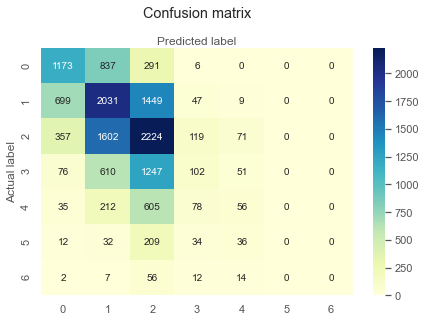

In [54]:
param_grid = {'max_features': ['auto'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7],
              'criterion' :['gini', 'entropy']
             }

dtree_model(X_train, y_train, X_test, y_test, param_grid)

### Decision Tree using Recursive Feature Elimination Variables

Fitting 15 folds for each of 18 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   45.0s finished


{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto'}
Train data accuracy score:  0.4383354744626923
Test data accuracy score:  0.42642872022776196
classification report :
               precision    recall  f1-score   support

           0       0.48      0.60      0.54      1841
           1       0.56      0.41      0.47      5833
           2       0.55      0.40      0.46      5971
           3       0.09      0.31      0.14       599
           4       0.06      0.35      0.10       157
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.43     14401
   macro avg       0.25      0.30      0.24     14401
weighted avg       0.52      0.43      0.46     14401

confusion matrix: [[1112 1026  168    1    0    0    0]
 [ 506 2390 1316   23    0    0    0]
 [ 170 1644 2401  152    6    0    0]
 [  43  572 1261  183   27    0    0]
 [  10  157  618  146   55   

C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


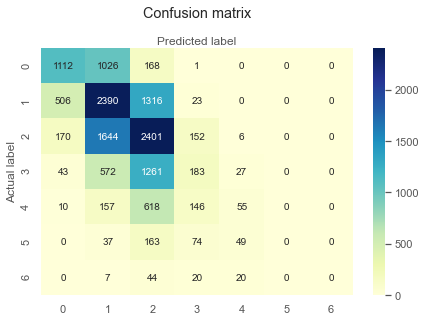

In [55]:
param_grid = {'max_features': ['auto'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7],
              'criterion' :['gini', 'entropy']
             }

dtree_model(X_train_rfe, y_train, X_test_rfe, y_test, param_grid)

## Random Forest Classifier

### Random Forest Classifier (All Features)

In [56]:
# Get class weight
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

print(class_weight)
print(loan_data.grade.value_counts())

[ 0.89192035  0.48570754  0.47051616  0.98631873  2.08589535  6.35924045
 22.66902794]
2    21862
1    21177
0    11533
3    10429
4     4931
5     1617
6      454
Name: grade, dtype: int64


In [57]:
def rfc_modeling(classifier, x_train, y_train, x_test, y_test, param, **kwargs):
#     cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([('algo',classifier(**kwargs))])
    model = GridSearchCV(pipeline,param,cv=cv,n_jobs=-1,verbose=1)
    model.fit(x_train,y_train)

    print(model.best_params_)
    print("Train data accuracy score: ", model.score(x_train,y_train))
    print("Test data accuracy score: ", model.score(x_test,y_test))
    
    return model
    
    

In [58]:
def rfc_model(classifier, X_train, y_train, X_test, y_test, param_rf):
    rfc = rfc_modeling(classifier, X_train, y_train, X_test, y_test, param_rf, n_jobs=-1,random_state=42)
    val_pred = rfc.predict(X_test)
    val_pred
    print("classification report :\n",classification_report(val_pred,y_test))
    return evaluate_model(val_pred, X_test, y_test)
    
    

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.8min finished


{'algo__class_weight': {2.0: 22.66, 1.0: 6.35, 0.0: 2.09, 3.0: 0.99, 4.0: 0.89, 5.0: 0.49, 6.0: 0.47}, 'algo__max_depth': 6, 'algo__max_features': 0.5, 'algo__min_samples_leaf': 63, 'algo__n_estimators': 200}
Train data accuracy score:  0.3357175098086872
Test data accuracy score:  0.3347684188598014


C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report :
               precision    recall  f1-score   support

           0       0.16      0.87      0.28       435
           1       0.02      0.27      0.03       285
           2       1.00      0.32      0.48     13651
           3       0.00      1.00      0.00         2
           4       0.01      0.21      0.01        28
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.33     14401
   macro avg       0.17      0.38      0.12     14401
weighted avg       0.95      0.33      0.47     14401

confusion matrix: [[ 379  201 1727    0    0    0    0]
 [  47   76 4112    0    0    0    0]
 [   9    6 4358    0    0    0    0]
 [   0    2 2079    2    3    0    0]
 [   0    0  980    0    6    0    0]
 [   0    0  310    0   13    0    0]
 [   0    0   85    0    6    0    0]]


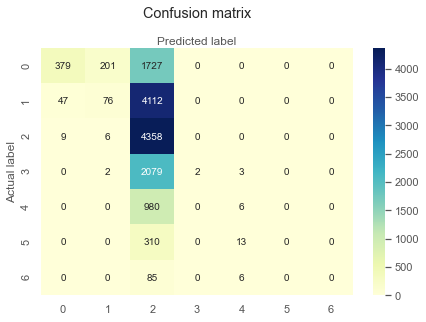

In [59]:
param_rf = {
    'algo__n_estimators':[200],
    'algo__max_depth':[6],
    'algo__max_features':[0.5],
    'algo__min_samples_leaf':[63],
    'algo__class_weight':[{2.0:22.66,
                           1.0:6.35,
                           0.0:2.09,
                           3.0:0.99,
                            4.0:0.89,
                            5.0:0.49,
                            6.0:0.47}]
}

rfc_model(RandomForestClassifier, X_train, y_train, X_test, y_test, param_rf)

### Random Forest using Recursive Feature Elimination

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.4min finished


{'algo__class_weight': {2.0: 22.66, 1.0: 6.35, 0.0: 2.09, 3.0: 0.99, 4.0: 0.89, 5.0: 0.49, 6.0: 0.47}, 'algo__max_depth': 6, 'algo__max_features': 0.5, 'algo__min_samples_leaf': 63, 'algo__n_estimators': 200}
Train data accuracy score:  0.333755772369015
Test data accuracy score:  0.33344906603708074


C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report :
               precision    recall  f1-score   support

           0       0.17      0.86      0.29       463
           1       0.01      0.20      0.01       167
           2       1.00      0.32      0.48     13753
           3       0.00      1.00      0.00         2
           4       0.01      0.31      0.01        16
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0

    accuracy                           0.33     14401
   macro avg       0.17      0.38      0.11     14401
weighted avg       0.96      0.33      0.47     14401

confusion matrix: [[ 399  132 1776    0    0    0    0]
 [  55   33 4147    0    0    0    0]
 [   8    2 4363    0    0    0    0]
 [   1    0 2082    2    1    0    0]
 [   0    0  981    0    5    0    0]
 [   0    0  316    0    7    0    0]
 [   0    0   88    0    3    0    0]]


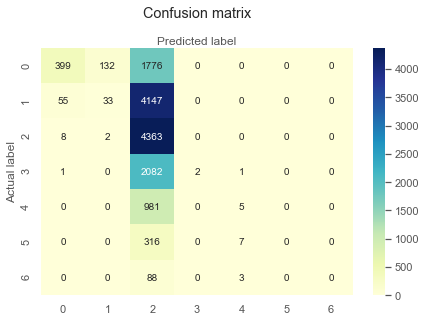

In [60]:
param_rf = {
    'algo__n_estimators':[200],
    'algo__max_depth':[6],
    'algo__max_features':[0.5],
    'algo__min_samples_leaf':[63],
    'algo__class_weight':[{2.0:22.66,
                           1.0:6.35,
                           0.0:2.09,
                           3.0:0.99,
                            4.0:0.89,
                            5.0:0.49,
                            6.0:0.47}]
}

rfc_model(RandomForestClassifier, X_train_rfe, y_train, X_test_rfe, y_test, param_rf)

## XGBoost

In [61]:
# import XGBoost
import xgboost as xgb
from xgboost import cv


In [62]:
from sklearn.model_selection import train_test_split
X = loan_data.drop(columns=['id','grade'])
y = loan_data.grade

X = transform(X)

# split X and y into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((57602, 58), (14401, 58), (57602,), (14401,))

In [63]:
# import XGBClassifier
from xgboost import XGBClassifier
params = {
            'objective':'multi:softmax',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100,
            'num_class':7
        }                  
# Create XGB model instance
xgb_clf = XGBClassifier(**params)

# fit the classifier 
xgb_clf.fit(X_train, y_train)


C:\Users\USER\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1.0, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_class=7, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=10,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<Figure size 2880x1440 with 0 Axes>

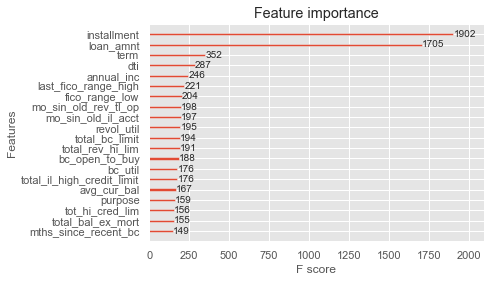

In [64]:
# Plot feature importance
plt.figure(figsize=(40,20))
xgb.plot_importance(xgb_clf,max_num_features=20)
# plt.rcParams["figure.figsize"] = (10,10)
plt.show()

### XGB Model Evaluation

Train data accuracy score:  0.8677650081594389
Test data accuracy score:  0.7691826956461357
classification report :
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      2199
           1       0.83      0.81      0.82      4331
           2       0.83      0.76      0.80      4782
           3       0.62      0.67      0.65      1939
           4       0.52      0.58      0.55       890
           5       0.36      0.52      0.43       225
           6       0.15      0.40      0.22        35

    accuracy                           0.77     14401
   macro avg       0.60      0.66      0.62     14401
weighted avg       0.78      0.77      0.77     14401

confusion matrix: [[1969  319   19    0    0    0    0]
 [ 203 3513  500   18    1    0    0]
 [  24  441 3649  244   14    1    0]
 [   1   51  545 1301  184    3    1]
 [   2    6   63  344  514   50    7]
 [   0    1    6   28  158  117   13]
 [   0    0    0    4   19   54   14]]


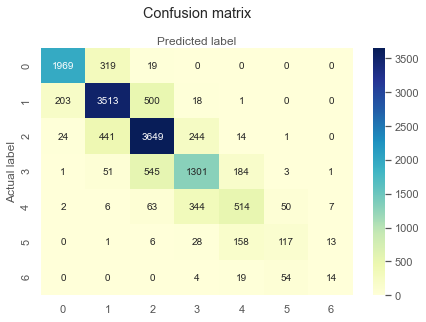

In [65]:
# make predictions on test data
val_pred = xgb_clf.predict(X_test)
print("Train data accuracy score: ", xgb_clf.score(X_train,y_train))
print("Test data accuracy score: ", xgb_clf.score(X_test,y_test))
print("classification report :\n",classification_report(val_pred,y_test))
evaluate_model(val_pred, X_test, y_test)

# Hyper Parameter Tuning For best performing model
* **The best performing model is XGBoost model**

In [66]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, 
                    objective='multi:softmax', num_classes=7, silent=True)

In [65]:
# folds = 3
# param_comb = 3

# # skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1)
# # cv = RepeatedKFold(n_splits=folds, n_repeats=3, random_state=1)
# xgb_model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=1)

# xgb_model.fit(X_train, y_train)
# print('--------------------BEST PARAMETERS-------------------------')
# print(xgb_model.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 70.1min finished
C:\Users\USER\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "num_classes", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:56:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
--------------------BEST PARAMETERS-------------------------
{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.8}


**Results from hyperparameter tuning gave best parameters**
{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 2, 'colsample_bytree': 0.8}

# Final Model and Evaluation

**XGBOOST MODEL**

In [67]:
params = {
            'objective':'multi:softmax',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100,
            'num_class':7,
            'subsample': 0.8,
            'min_child_weight': 1,
            'max_depth': 5,
            'gamma': 2,
            'colsample_bytree': 0.8
        }                   
# Create XGB model instance
final_xgb_clf = XGBClassifier(**params)

# fit the classifier 
final_xgb_clf.fit(X_train, y_train)


[13:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=1.0, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_class=7, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=10,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train data accuracy score:  0.8341550640602757
Test data accuracy score:  0.7580723560863829
classification report :
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      2186
           1       0.83      0.80      0.82      4382
           2       0.83      0.75      0.79      4823
           3       0.59      0.64      0.61      1919
           4       0.47      0.56      0.51       833
           5       0.33      0.50      0.40       216
           6       0.21      0.45      0.29        42

    accuracy                           0.76     14401
   macro avg       0.59      0.66      0.61     14401
weighted avg       0.77      0.76      0.76     14401

confusion matrix: [[1950  339   18    0    0    0    0]
 [ 205 3524  483   21    2    0    0]
 [  28  458 3623  245   17    2    0]
 [   1   52  619 1228  182    4    0]
 [   2    8   75  381  465   49    6]
 [   0    1    5   40  152  108   17]
 [   0    0    0    4   15   53   19]]


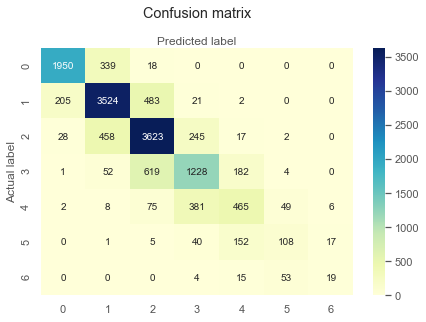

In [68]:
# make predictions on test data
val_pred = final_xgb_clf.predict(X_test)
print("Train data accuracy score: ", final_xgb_clf.score(X_train,y_train))
print("Test data accuracy score: ", final_xgb_clf.score(X_test,y_test))
print("classification report :\n",classification_report(val_pred,y_test))
evaluate_model(val_pred, X_test, y_test)

# Create Submission File

In [69]:
# Transform test data
ids = loan_data_test.id
loan_data_test_transformed = transform(loan_data_test)
loan_data_test_transformed.drop('id', inplace=True, axis=1)
loan_data_test_transformed


,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,15000.0,15000.0,0,535.54,6,0,83000.0,0,2,0,0,14.75,0,710.0,714.0,0,6,0.0,88.1,14,1,709.0,705.0,0,0.0,231842.0,26300.0,2,38640.0,856.0,95.8,169,232,28,16,4,83,0,2,4,2,5,3,4.0,7.0,4.0,6,0,0.0,100.0,100.0,0.0,242934.0,37641.0,20400.0,18634.0,0,0
1,10000.0,10000.0,0,325.62,2,2,63000.0,1,0,0,1,26.15,0,715.0,719.0,0,9,0.0,91.7,35,1,659.0,655.0,0,0.0,196024.0,14800.0,1,21780.0,401.0,97.3,115,107,35,5,0,35,0,3,3,3,3,23,3.0,4.0,3.0,9,0,1.0,100.0,100.0,0.0,228463.0,136649.8,14800.0,122961.6,0,0
2,18825.0,18825.0,0,644.22,10,2,42000.0,2,2,0,2,15.46,0,665.0,669.0,0,6,1.0,72.2,17,0,759.0,755.0,0,316.0,20338.0,10600.0,2,3390.0,2528.0,75.0,129,174,20,13,0,27,0,4,5,4,13,3,5.0,14.0,5.0,6,0,0.0,100.0,75.0,1.0,26079.0,20338.0,10100.0,15479.0,0,0
4,14000.0,14000.0,1,323.37,2,2,45000.0,1,2,0,1,20.27,0,695.0,699.0,0,8,0.0,87.1,41,0,709.0,705.0,0,0.0,56960.0,14400.0,1,8137.0,1824.0,86.9,125,180,16,16,0,16,0,2,3,3,9,22,5.0,18.0,3.0,8,0,0.0,100.0,66.7,0.0,66706.0,56960.0,13900.0,52184.0,0,0
5,5600.0,5600.0,0,191.35,3,2,50000.0,1,2,0,2,18.53,0,685.0,689.0,0,5,0.0,66.0,10,1,679.0,675.0,0,0.0,44943.0,14200.0,4,8989.0,4366.0,65.6,82,73,5,5,0,5,0,3,4,3,4,5,4.0,5.0,4.0,5,0,4.0,100.0,33.3,0.0,53576.0,44943.0,12700.0,39376.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,10000.0,10000.0,0,339.79,2,2,99000.0,2,1,0,4,17.85,0,670.0,674.0,0,17,0.0,62.6,20,1,544.0,540.0,0,0.0,77232.0,31800.0,10,4543.0,2635.0,84.6,92,57,7,7,0,7,0,3,8,3,5,6,11.0,14.0,8.0,17,0,2.0,100.0,66.7,0.0,95712.0,77232.0,17100.0,63912.0,0,0
74996,20000.0,20000.0,1,422.59,10,2,90000.0,1,2,0,1,8.67,0,710.0,714.0,1,12,0.0,45.4,31,0,789.0,785.0,0,0.0,40297.0,43600.0,3,3358.0,22795.0,46.5,149,191,3,3,0,3,0,4,4,8,14,10,9.0,21.0,4.0,12,0,3.0,90.3,12.5,0.0,77439.0,40297.0,42600.0,33839.0,0,0
74997,17500.0,17500.0,1,376.06,10,0,92500.0,0,1,0,2,23.19,0,700.0,704.0,1,20,0.0,67.0,34,0,544.0,540.0,0,0.0,325308.0,69700.0,4,17121.0,22035.0,67.9,186,196,2,2,1,2,0,8,11,10,17,5,14.0,23.0,11.0,20,0,2.0,100.0,33.3,0.0,383264.0,86219.0,64300.0,57564.0,0,0
74998,17000.0,17000.0,0,575.51,3,0,46000.0,2,2,0,2,21.76,0,680.0,684.0,0,15,0.0,74.9,33,0,709.0,705.0,0,0.0,79523.0,24300.0,5,5302.0,1198.0,92.7,130,163,4,4,1,23,1,6,10,6,15,8,13.0,23.0,10.0,15,0,2.0,97.0,100.0,0.0,100620.0,27200.0,16400.0,11520.0,0,0


In [70]:
#We align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets
#Match the columns in the dataframes
train = X_train.copy()
train, loan_data_test_transformed = loan_data_test_transformed.align(loan_data_test_transformed, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', loan_data_test_transformed.shape)

Training shape:  (71837, 58)
Testing shape:  (71837, 58)


In [73]:
# Final Submission
test_predictions = final_xgb_clf.predict(loan_data_test_transformed)
submission = pd.DataFrame({ 'id': ids, 'predicted_grade': test_predictions})
# Reverse grade mapping
rev_grade_map = {
    0:'A',
    1:'B',
    2:'C',
    3:'D',
    4:'E',
    5:'F',
    6:'G',
}

submission.predicted_grade = submission.predicted_grade.map(rev_grade_map)
#Save as csv
submission.to_csv("DM_Angalabiri_submission.csv", index=False)
submission.head(20)


,id,predicted_grade
0,7680704.0,D
1,78820328.0,B
2,5777448.800000001,D
4,67436726.0,C
5,10504869.0,C
6,64161369.0,D
7,46601412.0,C
8,40363003.0,C
9,114297423.2,C
10,49066351.0,D
